# Brick 23 Optical+IR Modelling and Fitting

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
# %config InlineBackend.figure_format='svg'

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import cubehelix

import os
import time
from glob import glob
import numpy as np

brick = 23
STARFISH = os.getenv("STARFISH")
isoc_dir = "b23oir_isoc"
lib_dir = "b23oir_lib"
synth_dir = "b23oir_synth"
fit_ir_dir = "b23oir_fit_ir"
wfc3_bands = ['F475W', 'F814W', 'F110W', 'F160W']

In [2]:
from astropy.coordinates import Distance
import astropy.units as u

from padova import AgeGridRequest, IsochroneRequest
from starfisher import LibraryBuilder

z_grid = [0.015, 0.019, 0.024]
delta_gyr = 0.5
late_ages = np.log10(np.arange(1e9 + delta_gyr, 13e9, delta_gyr * 1e9))
if not os.path.exists(os.path.join(STARFISH, isoc_dir)):
    for z in z_grid:
        # Young ages in log-grid
        r = AgeGridRequest(z,
                           min_log_age=6.6,
                           max_log_age=8.9,
                           delta_log_age=0.1,
                           phot='wfc3', photsys_version='odfnew')
        for isoc in r.isochrone_set:
            isoc.export_for_starfish(os.path.join(STARFISH, isoc_dir),
                                     bands=wfc3_bands)
        
        # Old ages in linear grid
        for logage in late_ages:
            r = IsochroneRequest(z, logage,
                                 phot='wfc3', photsys_version='odfnew')
            r.isochrone.export_for_starfish(os.path.join(STARFISH, isoc_dir),
                                     bands=wfc3_bands)

d = Distance(785 * u.kpc)
builder = LibraryBuilder(isoc_dir, lib_dir,
                         nmag=len(wfc3_bands),
                         dmod=d.distmod.value,
                         iverb=3)
if not os.path.exists(builder.full_isofile_path):
    builder.install()

In [3]:
from collections import namedtuple
from starfisher import Lockfile
from starfisher import Synth
from starfisher import ExtinctionDistribution
from starfisher import ExtantCrowdingTable
from starfisher import MockNullCrowdingTable
from starfisher import ColorPlane
from m31hst.phatast import PhatAstTable

if not os.path.exists(os.path.join(STARFISH, synth_dir)):
    os.makedirs(os.path.join(STARFISH, synth_dir))

# No binning in our lockfile
lockfile = Lockfile(builder.read_isofile(), synth_dir, unbinned=False)

# Bin young isochrones
young_grid = np.linspace(6.5, 8.95, 10)
for i, logage0 in enumerate(young_grid[:-1]):
    logage0 = logage0
    logage1 = young_grid[i + 1]
    z_str = "0019"
    mean_age = (logage0 + logage1) / 0.2
    name = "z{0}_{1:05.2f}".format(z_str, mean_age)
    lockfile.lock_box(name, (logage0, logage1), (0.014, 0.025))

# Bin old isochrones
old_grid = np.arange(1e9, 14 * 1e9, 1e9)
for i, age0 in enumerate(old_grid[:-1]):
    logage0 = np.log10(age0 - 0.05 * 1e9)
    logage1 = np.log10(old_grid[i + 1])
    z_str = "0019"
    mean_age = (logage0 + logage1) / 0.2
    name = "z{0}_{1:05.2f}".format(z_str, mean_age)
    lockfile.lock_box(name, (logage0, logage1), (0.014, 0.025))

/Users/jsick/.virtualenvs/starfish/lib/python2.7/site-packages/matplotlib/figure.py:387: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


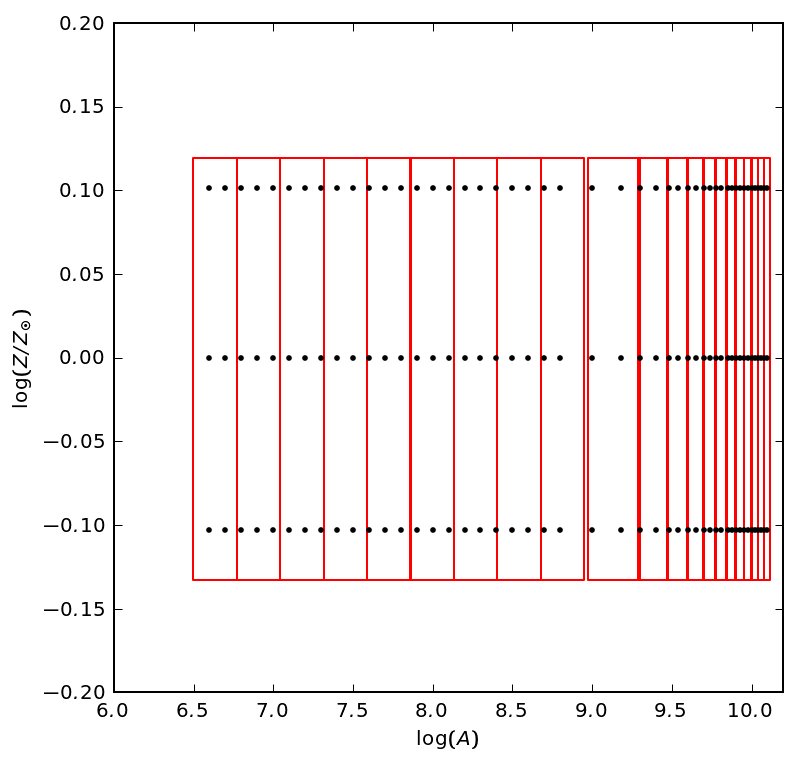

In [4]:
from starfisher.plots import plot_lock_polygons, plot_isochrone_logage_logzsol

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)
plot_isochrone_logage_logzsol(ax, builder, c='k', s=8)
plot_lock_polygons(ax, lockfile, facecolor='None', edgecolor='r')
ax.set_xlim(6, 10.2)
ax.set_ylim(-0.2, 0.2)
ax.set_xlabel(r"$\log(A)$")
ax.set_ylabel(r"$\log(Z/Z_\odot)$")
fig.show()

In [5]:
# No extinction, yet
young_av = ExtinctionDistribution()
old_av = ExtinctionDistribution()
rel_extinction = np.ones(len(wfc3_bands), dtype=float)
for av in (young_av, old_av):
    av.set_uniform(0.)

# Use PHAT AST from the outer field
crowd_path = os.path.join(synth_dir, "crowding.dat")
full_crowd_path = os.path.join(STARFISH, crowd_path)
tbl = PhatAstTable()
tbl.write_crowdfile_for_field(full_crowd_path, 0, bands=('f475w', 'f814w', 'f110w', 'f160w'))
crowd = ExtantCrowdingTable(crowd_path)
# crowd = MockNullCrowdingTable(crowd_path, 4, mag_range=(10., 35.))

# Define CMD planes
Lim = namedtuple('Lim', 'x y')

ir_lim = Lim(x=(0.3, 1.3), y=(24, 16.5))
ir_cmd = ColorPlane((wfc3_bands.index('F110W'),
                     wfc3_bands.index('F160W')),
                    wfc3_bands.index('F160W'),
                    ir_lim.x,
                    (min(ir_lim.y), max(ir_lim.y)),
                    30.,
                    suffix='f110f160',
                    x_label=r'$\mathrm{F110W}-\mathrm{F160W}$',
                    y_label=r'$\mathrm{F110W}$',
                    dpix=0.05)
ir_cmd.mask_region((-1., 0.), (22., 16))
ir_cmd.mask_region((0, 0.3), (22., 16))
ir_cmd.mask_region((0.3, 0.7), (20., 16))
ir_cmd.mask_region((0.7, 0.8), (19., 16))
ir_cmd.mask_region((0.8, 0.9), (18., 16))
ir_cmd.mask_region((1.1, 1.5), (28, 21))

opt_lim = Lim(x=(-1, 5), y=(25.5, 20))
opt_cmd = ColorPlane((wfc3_bands.index('F475W'),
                     wfc3_bands.index('F814W')),
                     wfc3_bands.index('F814W'),
                     opt_lim.x,
                     (min(opt_lim.y), max(opt_lim.y)),
                     30.,
                     suffix='f475f814',
                     x_label=r'$\mathrm{F475W}-\mathrm{F814W}$',
                     y_label=r'$\mathrm{F814W}$',
                     dpix=0.05)
opt_cmd.mask_region((3, 5), (28, 25))
opt_cmd.mask_region((3.5, 5), (25, 23))
opt_cmd.mask_region((4, 5), (23, 22.5))

colour_planes = [opt_cmd, ir_cmd]
synth = Synth(synth_dir, builder, lockfile, crowd,
              rel_extinction,
              young_extinction=young_av,
              old_extinction=old_av,
              planes=colour_planes,
              mass_span=(0.08, 150.),
              nstars=10000000)
if len(glob(os.path.join(STARFISH, synth_dir, "z*"))) == 0:
    synth.run_synth(n_cpu=4)
    # synth.plot_all_hess(os.path.join(STARFISH, synth_dir, 'hess'))

In [6]:
from astropy.table import Table
from m31hst import phat_v2_phot_path

brick_table = Table.read(phat_v2_phot_path(brick), format='fits')

/Users/jsick/phat_data


In [7]:
from starfisher import SimHess

optsim = SimHess(synth, opt_cmd, np.ones(len(lockfile.active_groups)))
irsim = SimHess(synth, ir_cmd, np.ones(len(lockfile.active_groups)))

/Users/jsick/code/_starfish/starfisher/starfisher/plots.py:54: RuntimeWarning: divide by zero encountered in log10
  hess = np.log10(hess)
/Users/jsick/.virtualenvs/starfish/lib/python2.7/site-packages/matplotlib/contour.py:931: UserWarning: linewidths is ignored by contourf
  warnings.warn('linewidths is ignored by contourf')


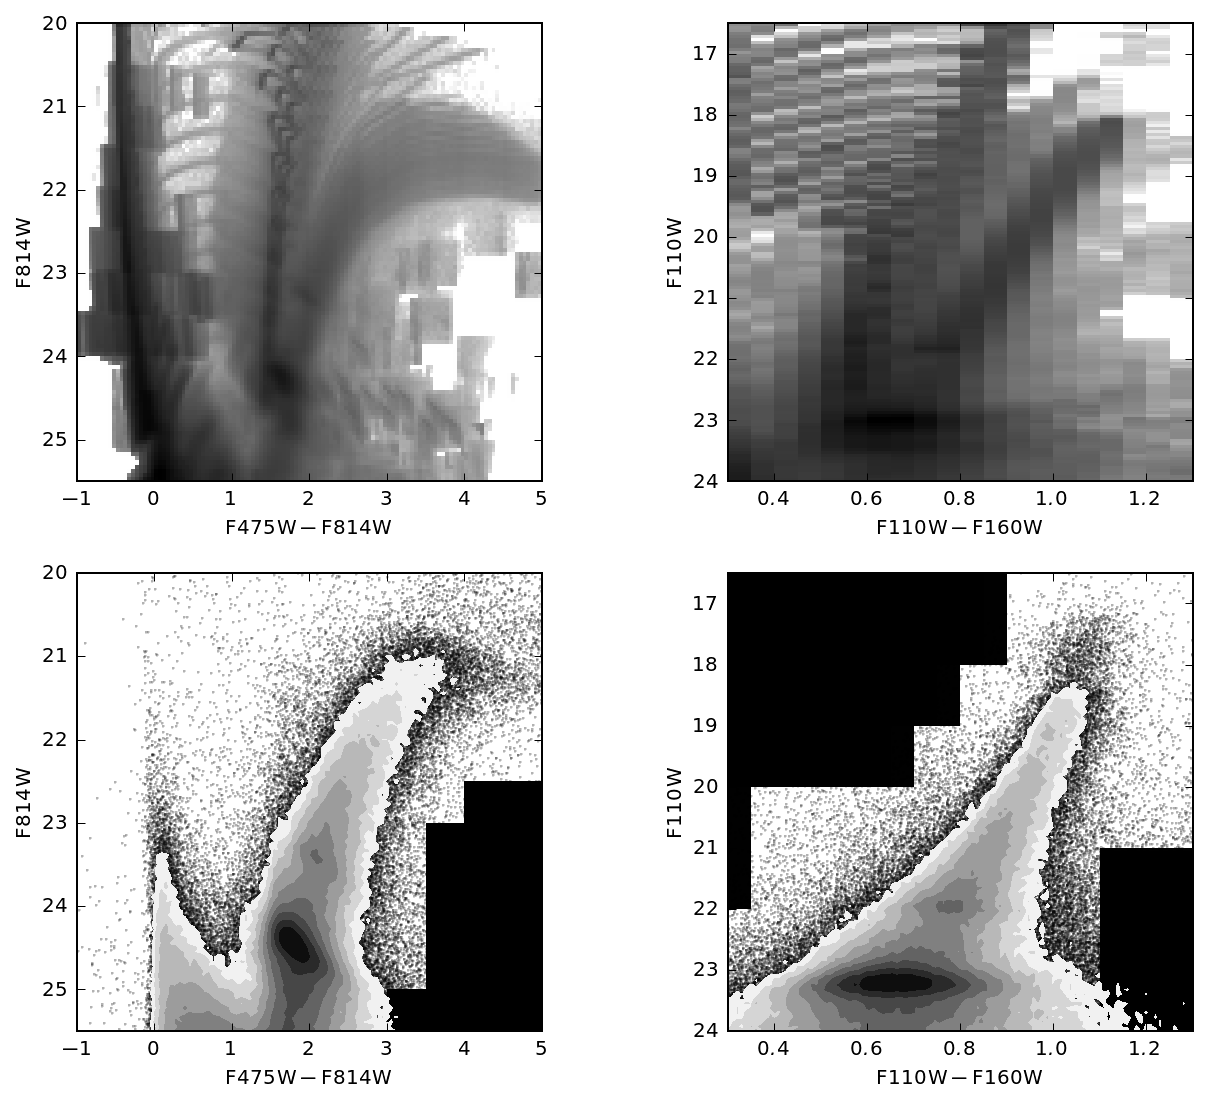

In [8]:
from starfisher.plots import plot_hess
from androcmd.plot import contour_hess

fig = plt.figure(figsize=(10, 10))
gs = GridSpec(2, 2, wspace=0.4, bottom=0.2)
ax_opt = fig.add_subplot(gs[0, 0])
ax_ir = fig.add_subplot(gs[0, 1])
ax_obs_opt = fig.add_subplot(gs[1, 0])
ax_obs_ir = fig.add_subplot(gs[1, 1])

plot_hess(ax_opt, optsim.hess, opt_cmd, optsim.origin, imshow_args=None)
plot_hess(ax_ir, irsim.hess, ir_cmd, irsim.origin, imshow_args=None)

contour_hess(ax_obs_opt, brick_table['f475w_vega'] - brick_table['f814w_vega'],
             brick_table['f814w_vega'], opt_cmd.x_span, opt_cmd.y_span,
             plot_args={'ms': 3})
opt_cmd.plot_mask(ax_obs_opt)
ax_obs_opt.set_xlabel(opt_cmd.x_label)
ax_obs_opt.set_ylabel(opt_cmd.y_label)
ax_obs_opt.set_xlim(opt_cmd.xlim)
ax_obs_opt.set_ylim(opt_cmd.ylim)

contour_hess(ax_obs_ir, brick_table['f110w_vega'] - brick_table['f160w_vega'],
             brick_table['f160w_vega'], ir_cmd.x_span, ir_cmd.y_span,
             plot_args={'ms': 3})
ir_cmd.plot_mask(ax_obs_ir)
ax_obs_ir.set_xlabel(ir_cmd.x_label)
ax_obs_ir.set_ylabel(ir_cmd.y_label)
ax_obs_ir.set_xlim(ir_cmd.xlim)
ax_obs_ir.set_ylim(ir_cmd.ylim)

fig.show()

In [9]:
logage_hess = optsim.mean_logage_hess

In [10]:
logage_hess.shape

(110, 120)

In [11]:
H = optsim.hess

In [12]:
H.shape

(110, 120)

In [13]:
logage_hess.max()

10.09

In [14]:
logage_hess.min()

6.6499999999999986

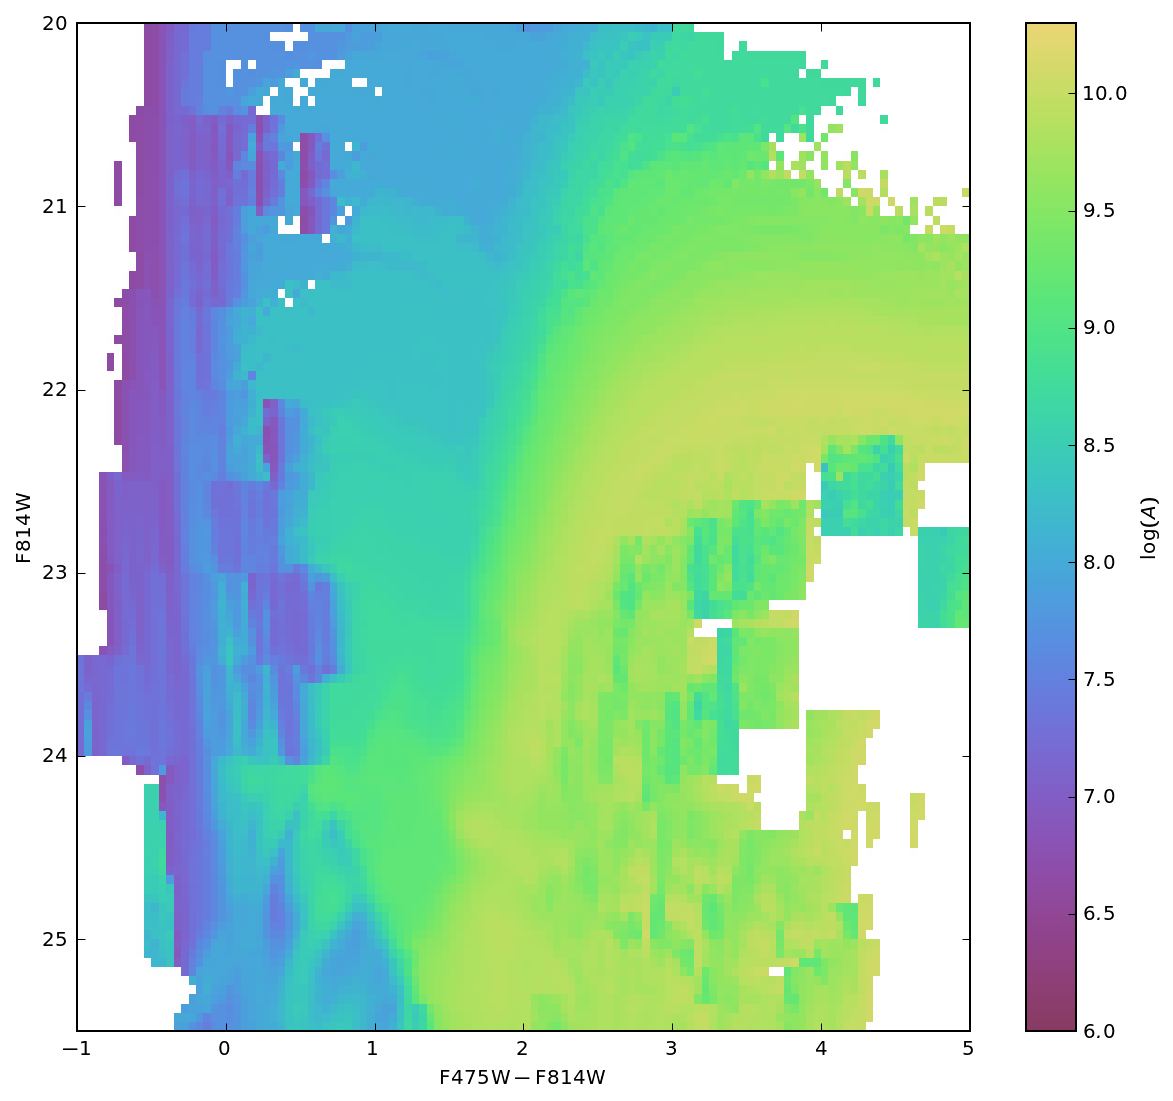

In [18]:
cmapper = lambda: cubehelix.cmap(startHue=240,endHue=-300,minSat=1,maxSat=2.5,minLight=.3,maxLight=.8,gamma=.9)
imshow_args = {'cmap': cmapper(), 'vmin': 6., 'vmax': 10.3}
fig = plt.figure(figsize=(10, 10))
gs = GridSpec(1, 1, wspace=0.4, bottom=0.2)
ax = fig.add_subplot(gs[0, 0])
im = plot_hess(ax, optsim.mean_logage_hess, opt_cmd, optsim.origin,
               log=False, imshow_args=imshow_args)
cb = fig.colorbar(im, ax=ax)
cb.set_label(r"$\log(A)$")
fig.show()

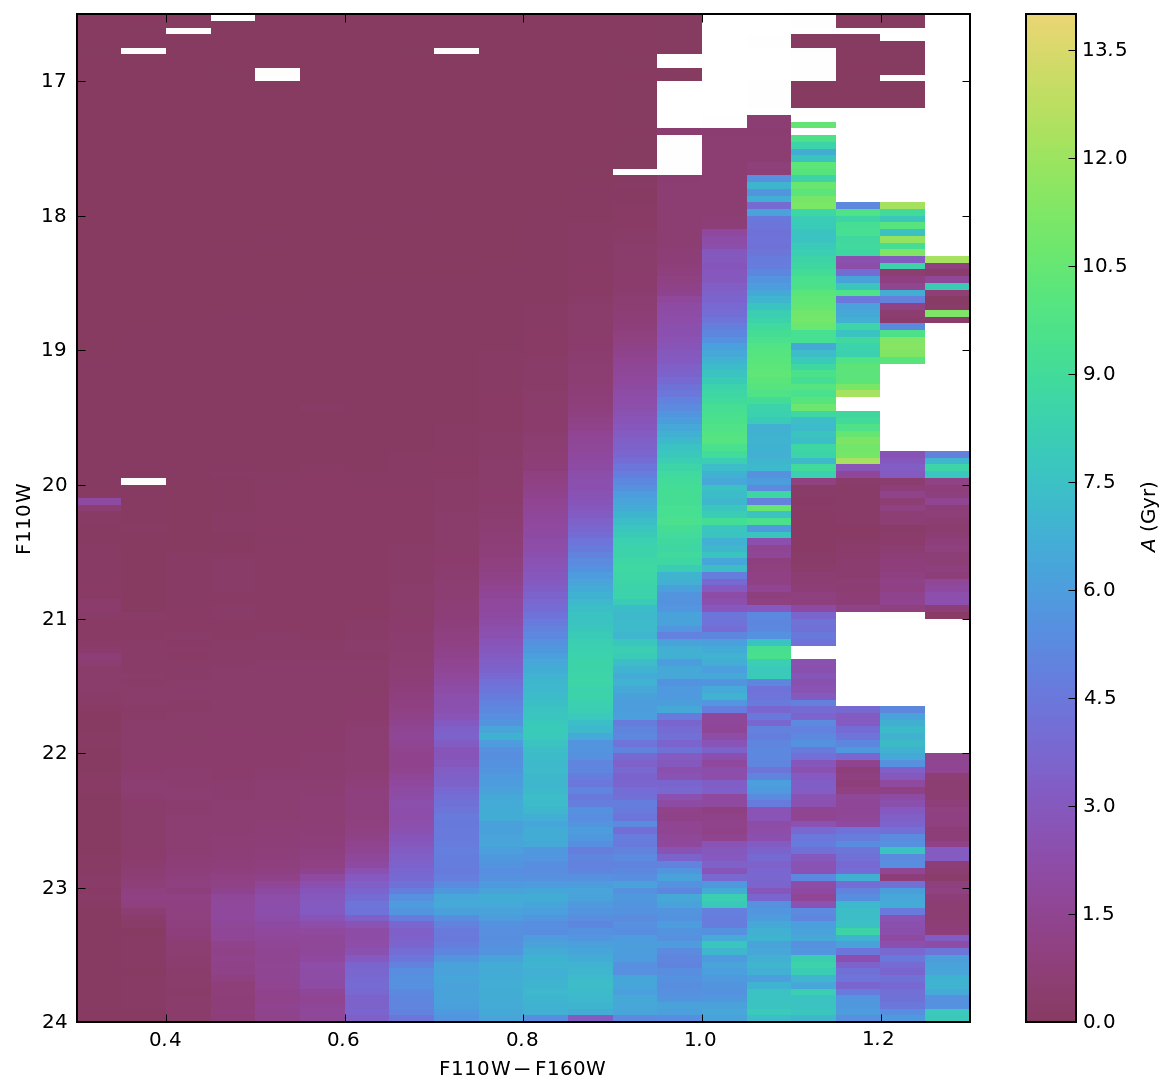

In [20]:
cmapper = lambda: cubehelix.cmap(startHue=240,endHue=-300,minSat=1,maxSat=2.5,minLight=.3,maxLight=.8,gamma=.9)
imshow_args = {'cmap': cmapper(), 'vmin': 0, 'vmax': 14}
fig = plt.figure(figsize=(10, 10))
gs = GridSpec(1, 1, wspace=0.4, bottom=0.2)
ax = fig.add_subplot(gs[0, 0])
im = plot_hess(ax, 10 ** irsim.mean_logage_hess / 1e9, ir_cmd, irsim.origin,
               log=False, imshow_args=imshow_args)
cb = fig.colorbar(im, ax=ax)
cb.set_label(r"$A$ (Gyr)")
fig.show()